In [2]:
#| code-summary: Load Packages
#| code-fold: true

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import plotly.express as px

# statistics
import statsmodels.api as sm

In [3]:
#| echo: false
from IPython.display import display, HTML
HTML('<style>.output {flex-direction: row;}</style>')
pd.options.display.notebook_repr_html = False

In [4]:
#| code-summary: Options
#| code-fold: true

# pandas options
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7

# Numpy options
np.set_printoptions(precision = 2, suppress=True)

In [5]:
wdi_data = (
    "https://raw.githubusercontent.com/nickeubank/"
    "practicaldatascience/master/Example_Data/wdi_plotting.csv"
)
world = pd.read_csv(wdi_data)

names = world.columns[3:].to_list()

names.append("GDP per capita (constant 2015 US$)")

countries = world["Country Code"].unique()

In [6]:
wdi = pd.read_parquet("../data/wdi.parquet")
wdi2 = wdi[wdi["Indicator Name"].isin(names) & wdi["Country Code"].isin(countries)].copy()

indic_name = wdi2["Indicator Name"].unique()

wdi2.columns = wdi2.columns.str.replace(" ", "_")
wdi2.rename(str.lower, axis=1, inplace=True)

dic = dict(zip(indic_name, ["CO2", "GDP", "life_exp", "literacy", "mortality", "child_mortality", "polution", "pop"]))
wdi2 = wdi2.replace({"indicator_name": dic})

years = wdi2.loc[:, '1960':'2021'].columns

wdi2_long1 = wdi2.melt(
    id_vars=wdi2.columns[:4], 
    value_vars=years, 
    value_name="values",
    var_name="year"
)

wdi2_long1 = wdi2_long1.drop(columns="indicator_code")

wdi2_long2 = wdi2_long1.pivot(
    index=["country_name",	"country_code", "year"], columns="indicator_name", 
    values="values"
)

wdi2_long2.columns.name = ""
wdi2_long2 = wdi2_long2.reset_index()
wdi2_long2["year"] = wdi2_long2.year.astype(int)



In [7]:
indicators = wdi["Indicator Name"].unique()
indicators = pd.Series(indicators)

indicators[indicators.str.contains("region")]

751    Merchandise exports to low- and middle-income ...
752    Merchandise exports to low- and middle-income ...
764    Merchandise imports from low- and middle-incom...
765    Merchandise imports from low- and middle-incom...
dtype: object

In [8]:
wdi_country = pd.read_csv("../data/WDICountry.csv")

wdi2_long2 = wdi2_long2.merge(wdi_country[["Country Code", "Short Name", "Region"]], left_on="country_code", right_on="Country Code", how="left")

wdi2_long2.drop(columns=["Country Code"], inplace=True)

wdi2_long2.rename(columns={"Region": "region", "Short Name": "country"}, inplace=True)

In [9]:
wdi2_long2.region.value_counts(dropna=False)

Europe & Central Asia         3596
Sub-Saharan Africa            2976
Latin America & Caribbean     2604
East Asia & Pacific           2294
Middle East & North Africa    1302
South Asia                     496
North America                  186
Name: region, dtype: int64

In [12]:
wdi_2020 = wdi2_long2.query('year == 2020')

wdi_2020 = wdi_2020.assign(
    log_gdp = lambda x: np.log(x.GDP),
    log_child_mortality = lambda x: np.log(x.child_mortality),
    log_pop = lambda x: np.log(x["pop"])
)

In [13]:
big_countries = wdi_2020.nlargest(10, "pop")["country"]
idx = wdi_2020["country"].isin(big_countries)
wdi_2020_big = wdi_2020[idx]

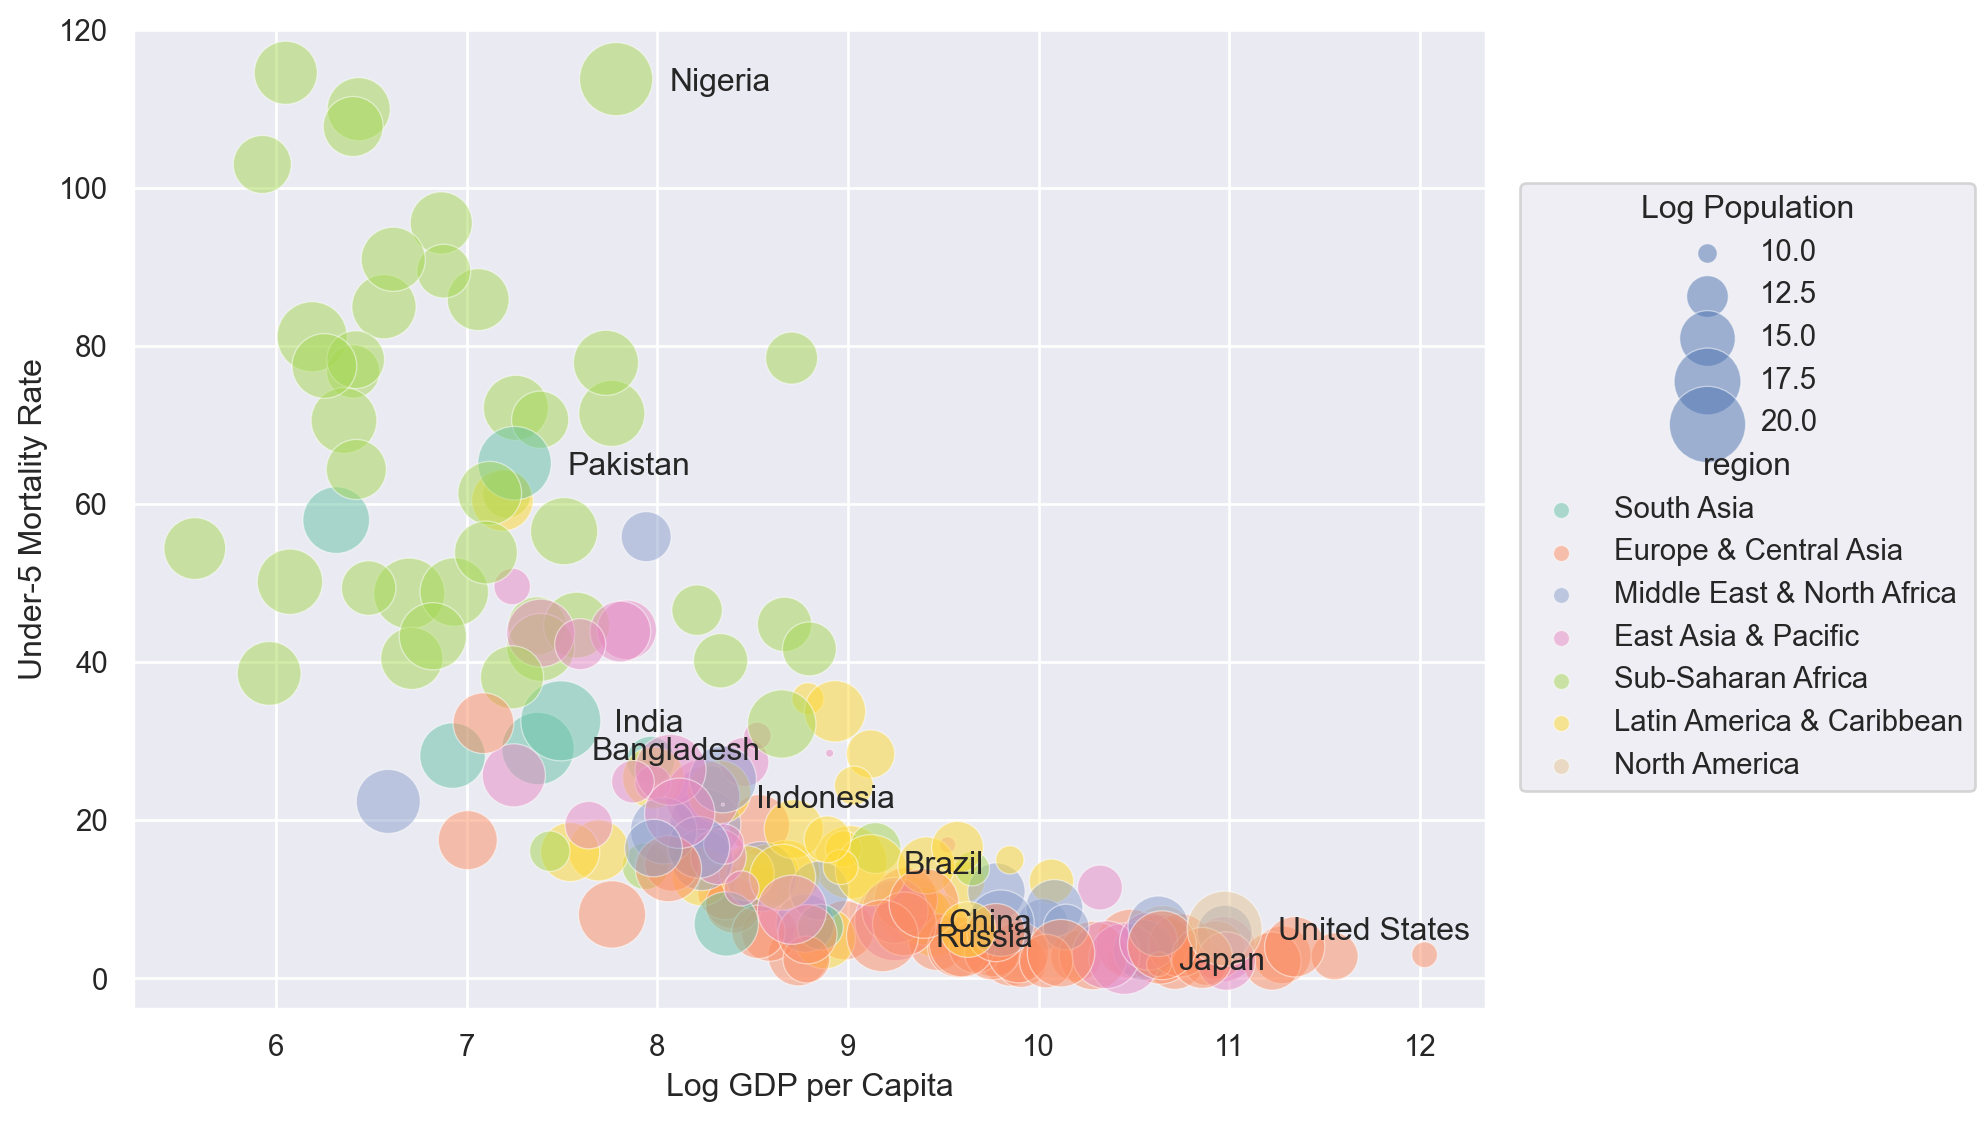

In [14]:
(
    so.Plot(wdi_2020, x="log_gdp", y="child_mortality")
    .add(so.Dot(edgecolor="white", alpha=.5), pointsize="log_pop", color="region")
    .scale(pointsize=(1, 30), color="Set2")
    .layout(size=(8, 6))
    .add(so.Text(halign="left", offset=20), 
         x=wdi_2020_big.log_gdp, 
         y=wdi_2020_big.child_mortality, 
         text=wdi_2020_big.country)
    .label(x="Log GDP per Capita", y="Under-5 Mortality Rate", pointsize="Log Population")
)

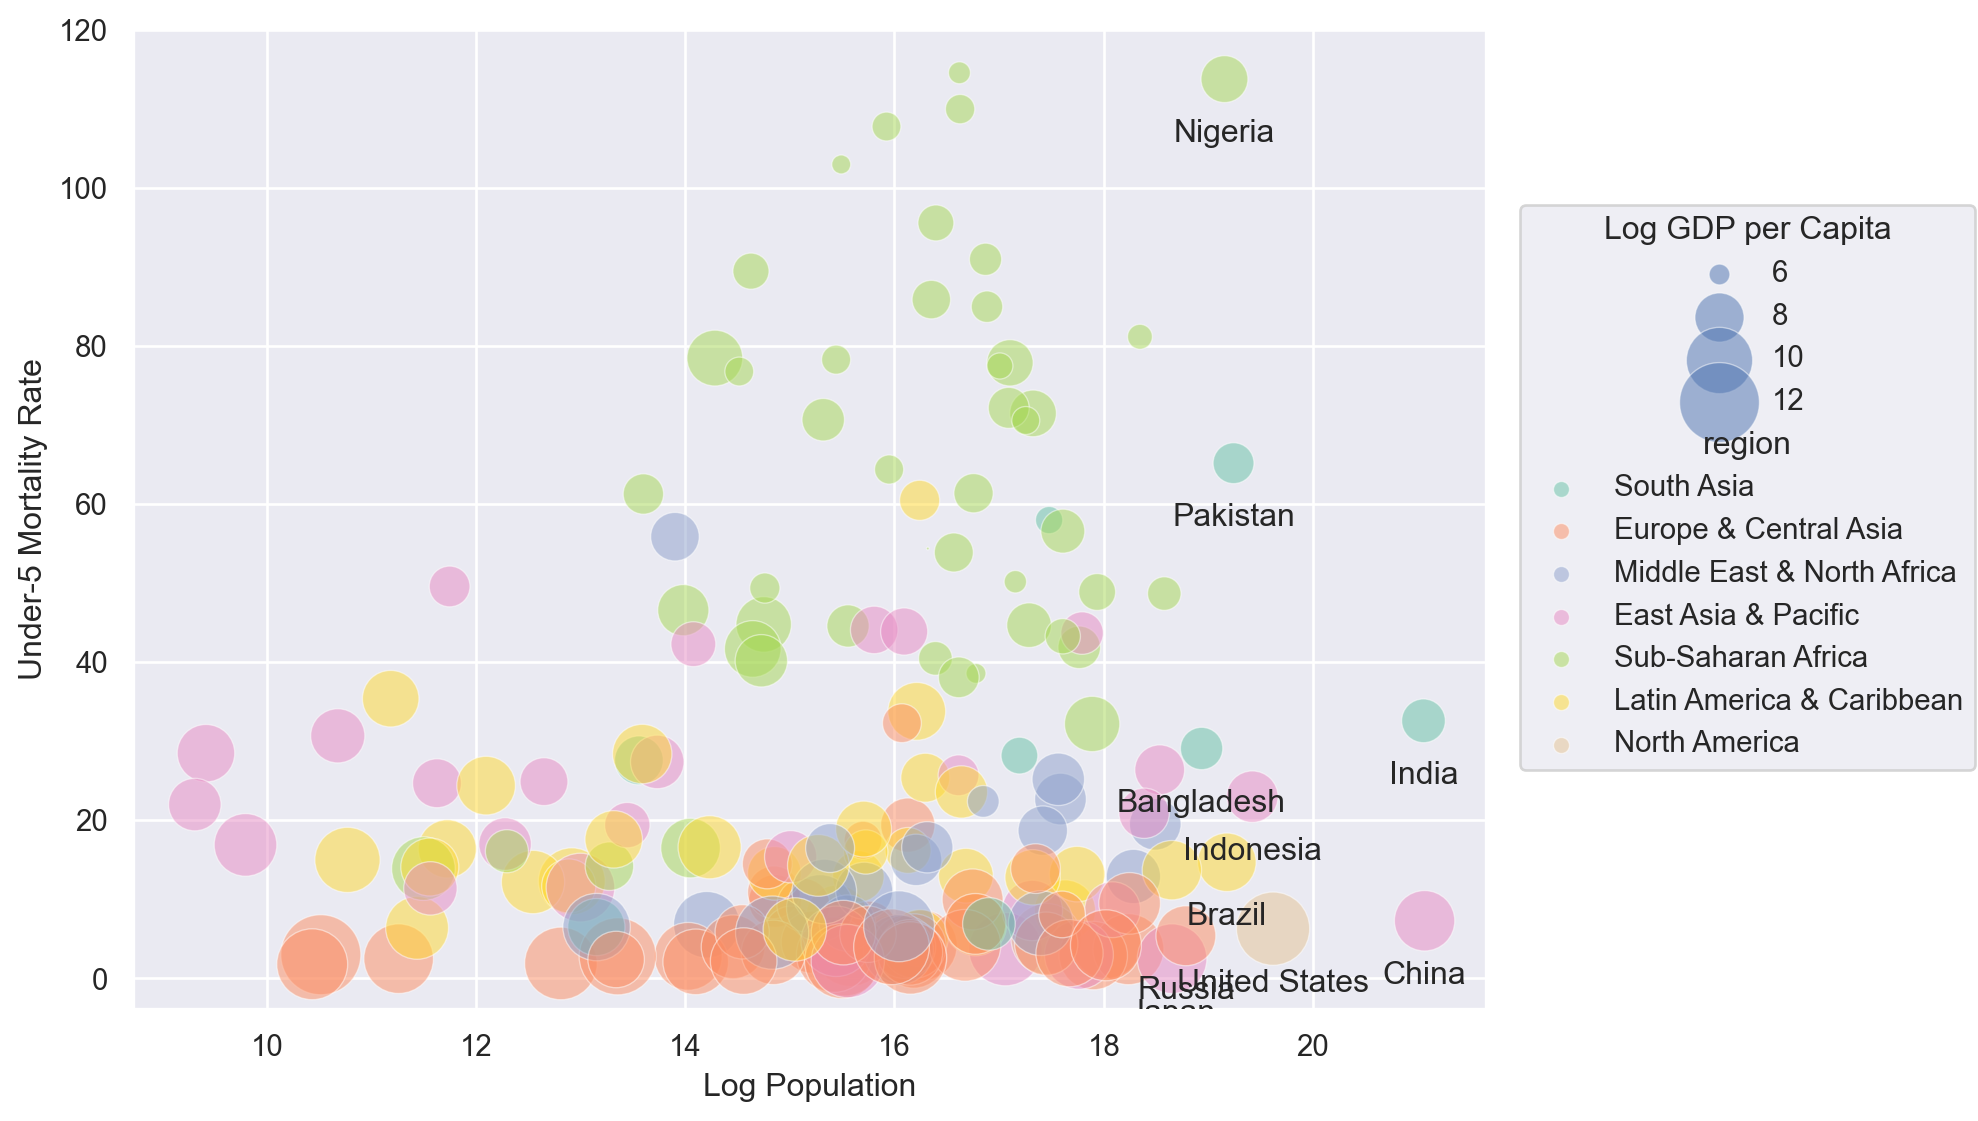

In [15]:
(
    so.Plot(wdi_2020, x="log_pop", y="child_mortality")
    .add(so.Dot(edgecolor="white", alpha=.5), pointsize="log_gdp", color="region")
    .scale(pointsize=(1, 30), color="Set2")
    .layout(size=(8, 6))
    .add(so.Text(valign="top", offset=15), 
         x=wdi_2020_big["log_pop"], 
         y=wdi_2020_big.child_mortality, 
         text=wdi_2020_big.country)
    .label(x="Log Population", y="Under-5 Mortality Rate", pointsize="Log GDP per Capita")
)

In [16]:
wdi_2020_2 = wdi_2020.dropna(subset=["log_gdp", "log_child_mortality", "pop"])

import plotly.express as px
import plotly.io as pio
#pio.renderers.default = "plotly_mimetype+notebook"

fig = px.scatter(wdi_2020_2, 
                 x="log_gdp", y="child_mortality", 
                 size="pop", size_max=40,
                 hover_name="country_name")
fig.show()

In [17]:
wdi_2020.head()

       country_name country_code  year  CO2      GDP  child_mortality  \
60      Afghanistan          AFG  2020  NaN   553.04            58.00   
122         Albania          ALB  2020  NaN  4410.46             9.80   
184         Algeria          DZA  2020  NaN  3873.51            22.70   
246  American Samoa          ASM  2020  NaN 14303.63              NaN   
308         Andorra          AND  2020  NaN 34394.28             2.50   

     life_exp  literacy  mortality  polution         pop         country  \
60      62.58       NaN        NaN       NaN 38972230.00     Afghanistan   
122     76.99       NaN        NaN       NaN  2837849.00         Albania   
184     74.45       NaN        NaN       NaN 43451666.00         Algeria   
246       NaN       NaN        NaN       NaN    46189.00  American Samoa   
308       NaN       NaN        NaN       NaN    77700.00         Andorra   

                         region  log_gdp  log_child_mortality  log_pop  
60                   South Asia

In [20]:
billboard = sm.datasets.get_rdataset("billboard", "tidyr").data

In [27]:
billboard

              artist                    track date.entered  wk1   wk2   wk3  \
0              2 Pac  Baby Don't Cry (Keep...   2000-02-26   87 82.00 72.00   
1            2Ge+her  The Hardest Part Of ...   2000-09-02   91 87.00 92.00   
2       3 Doors Down               Kryptonite   2000-04-08   81 70.00 68.00   
..               ...                      ...          ...  ...   ...   ...   
314  Ying Yang Twins  Whistle While You Tw...   2000-03-18   95 94.00 91.00   
315    Zombie Nation            Kernkraft 400   2000-09-02   99 99.00   NaN   
316  matchbox twenty                     Bent   2000-04-29   60 37.00 29.00   

      wk4   wk5   wk6   wk7  ...  wk67  wk68  wk69  wk70  wk71  wk72  wk73  \
0   77.00 87.00 94.00 99.00  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1     NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2   67.00 66.00 57.00 54.00  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
..    ...   ...   ...   ...  ...   ...   ...   ...   ..

billboard {tidyr}
Song rankings for Billboard top 100 in the year 2000

In [13]:
billboard = pd.read_csv("../data/billboard.csv")
billboard.head(6)

         artist                    track date.entered  wk1   wk2   wk3   wk4  \
0         2 Pac  Baby Don't Cry (Keep...   2000-02-26   87 82.00 72.00 77.00   
1       2Ge+her  The Hardest Part Of ...   2000-09-02   91 87.00 92.00   NaN   
2  3 Doors Down               Kryptonite   2000-04-08   81 70.00 68.00 67.00   
3  3 Doors Down                    Loser   2000-10-21   76 76.00 72.00 69.00   
4      504 Boyz            Wobble Wobble   2000-04-15   57 34.00 25.00 17.00   
5          98^0  Give Me Just One Nig...   2000-08-19   51 39.00 34.00 26.00   

    wk5   wk6   wk7  ...  wk67  wk68  wk69  wk70  wk71  wk72  wk73  wk74  \
0 87.00 94.00 99.00  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2 66.00 57.00 54.00  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3 67.00 65.00 55.00  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4 17.00 31.00 36.00  ...   NaN   NaN   NaN   NaN   NaN   Na

[MovieLens 1M Dataset](https://github.com/wesm/pydata-book/tree/3rd-edition/datasets/movielens)

In [5]:
movies = pd.read_csv("../data/movies.csv")
movies

      movie_id                    title       genre
0            1         Toy Story (1995)   Animation
1            1         Toy Story (1995)  Children's
2            1         Toy Story (1995)      Comedy
...        ...                      ...         ...
6405      3951  Two Family House (2000)       Drama
6406      3952    Contender, The (2000)       Drama
6407      3952    Contender, The (2000)    Thriller

[6408 rows x 3 columns]

In [6]:
users = pd.read_csv("../data/users.csv")
users

      user_id gender  age  occupation    zip
0           1      F    1          10  48067
1           2      M   56          16  70072
2           3      M   25          15  55117
...       ...    ...  ...         ...    ...
6037     6038      F   56           1  14706
6038     6039      F   45           0  01060
6039     6040      M   25           6  11106

[6040 rows x 5 columns]

In [8]:
ratings = pd.read_csv("../data/ratings.csv")
ratings

         user_id  movie_id  rating  timestamp
0              1      1193       5  978300760
1              1       661       3  978302109
2              1       914       3  978301968
...          ...       ...     ...        ...
1000206     6040       562       5  956704746
1000207     6040      1096       4  956715648
1000208     6040      1097       4  956715569

[1000209 rows x 4 columns]

[Baby Names](https://www.kaggle.com/datasets/kaggle/us-baby-names?select=NationalNames.csv)
             
**NationalNames.csv**

In [10]:
babynames = pd.read_csv("../data/NationalNames.csv")
babynames

              Id     Name  Year Gender  Count
0              1     Mary  1880      F   7065
1              2     Anna  1880      F   2604
2              3     Emma  1880      F   2003
...          ...      ...   ...    ...    ...
1825430  1825431  Zymiere  2014      M      5
1825431  1825432    Zyran  2014      M      5
1825432  1825433    Zyrin  2014      M      5

[1825433 rows x 5 columns]